# Generate tiled AOIs covering Local Government Areas (LGAs)

In [1]:
# Necessary imports
import os
import itertools
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from ml4floods.data import utils
from ml4floods.data.copernicusEMS.activations import generate_polygon
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore', 'Geometry is in a ', UserWarning)

In [2]:
# Access parameters for the ML4CC bucket
key_json = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/ml4cc-general-access_request_pays.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_json

## Load the NRRA-supplied local government area (LGA) polygons

In [3]:
# Read in the LGA shapefile and get a tuple of bounds (used for tiling later)
input_shapefile = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/EMSR570/LGA_Shapes/NSW_SQLD_February_Flooding_2022_LGA.shp"
lgas = gpd.read_file(input_shapefile).to_crs("EPSG:4326")
bounds_lgas = np.min(lgas.bounds.minx), np.min(lgas.bounds.miny), np.max(lgas.bounds.maxx), np.max(lgas.bounds.maxy)
print(f"[minX, minY, maxX, maxY] = {bounds_lgas}")
lgas.head()

[minX, minY, maxX, maxY] = (146.86329757882027, -37.50514655886656, 153.6387328362515, -23.244923299370726)


,LGA_CODE21,LGA_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,LGA_Code,lga_full_n,NSW_floods,NSW___NSW_,South_East,ObjectID,Shape_Le_1,Shape_Area,geometry
0,10180,Armidale Regional,1,New South Wales,AUS,Australia,7809.4406,http://linked.data.gov.au/dataset/asgsed3/LGA2...,6.034583,10180.0,Armidale Regional,1.0,0.0,0.0,1,6.034583,0.732825,"POLYGON ((151.32425 -30.26922, 151.32419 -30.2..."
1,10250,Ballina,1,New South Wales,AUS,Australia,484.9692,http://linked.data.gov.au/dataset/asgsed3/LGA2...,1.511121,10250.0,Ballina,1.0,0.0,0.0,2,1.511121,0.044843,"MULTIPOLYGON (((153.57106 -28.87381, 153.57106..."
2,10500,Bayside (NSW),1,New South Wales,AUS,Australia,50.6204,http://linked.data.gov.au/dataset/asgsed3/LGA2...,0.576415,10500.0,Bayside,1.0,1.0,0.0,3,0.576415,0.004937,"POLYGON ((151.14805 -33.92725, 151.14858 -33.9..."
3,10550,Bega Valley,1,New South Wales,AUS,Australia,6278.5013,http://linked.data.gov.au/dataset/asgsed3/LGA2...,6.140821,10550.0,Bega Valley,1.0,0.0,0.0,4,6.140821,0.634170,"MULTIPOLYGON (((150.05261 -37.26253, 150.05251..."
4,10600,Bellingen,1,New South Wales,AUS,Australia,1600.4338,http://linked.data.gov.au/dataset/asgsed3/LGA2...,2.311478,10600.0,Bellingen,1.0,0.0,0.0,5,2.311478,0.150235,"POLYGON ((152.47659 -30.39680, 152.47669 -30.3..."


<AxesSubplot:>

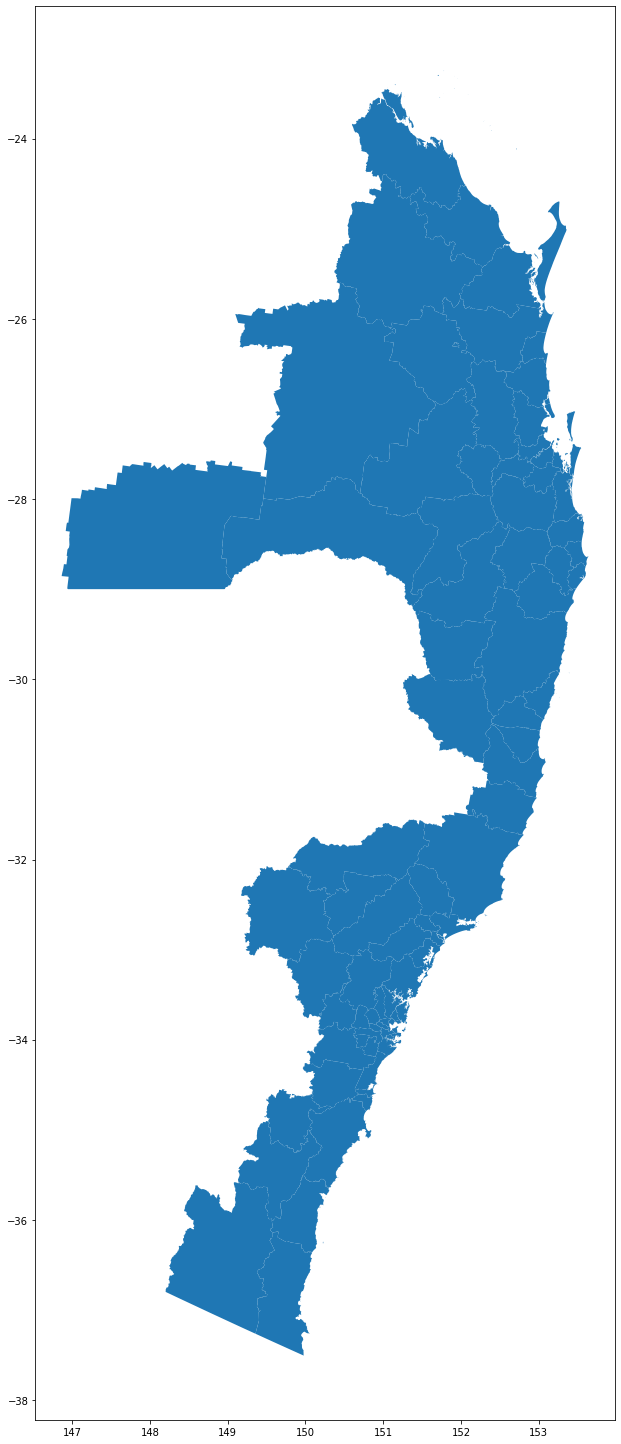

In [5]:
# Plot the LGAs
lgas.plot(figsize=(16, 26))

## Access and parse existing polygons on the bucket

In [12]:
# Access the Google bucket using fsutil.
# RESTRICT TO AUTOMATICALLY GENERATED 'AUTOAOI*' TILES.
fs = utils.get_filesystem("gs://ml4cc_data_lake")
path_pols_existing = "gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTO*/flood_meta/2022-*"

# Read existing polygons from pickles on bucket. Stored in pickels named:
# 0_DEV/1_Staging/operational/<EMS_CODE>/AOI*/flood_meta/2022-??-??.pickle
pols_existing = []
for meta_file in tqdm(fs.glob(path_pols_existing)):
    meta_file = f"gs://{meta_file}"
    meta = utils.read_pickle_from_gcp(meta_file)
    pols_existing.append({"geometry":meta["area_of_interest_polygon"], 
                          "ems_code":meta["ems_code"], 
                          "aoi_code":meta["aoi_code"], 
                          "date":meta["satellite date"]})
pols_existing = gpd.GeoDataFrame(pols_existing, crs="EPSG:4326")
pols_existing.head()

100%|██████████████████████████████████████████████████████████████████████| 663/663 [05:14<00:00,  2.11it/s]


,geometry,ems_code,aoi_code,date
0,"POLYGON ((146.86329 -29.10516, 147.07329 -29.1...",EMSR570,AUTOAOI001,2022-03-29
1,"POLYGON ((146.86329 -28.90516, 147.07329 -28.9...",EMSR570,AUTOAOI002,2022-03-29
2,"POLYGON ((146.86329 -28.70516, 147.07329 -28.7...",EMSR570,AUTOAOI003,2022-03-29
3,"POLYGON ((146.86329 -28.50516, 147.07329 -28.5...",EMSR570,AUTOAOI004,2022-03-29
4,"POLYGON ((146.86329 -28.30516, 147.07329 -28.3...",EMSR570,AUTOAOI005,2022-03-29


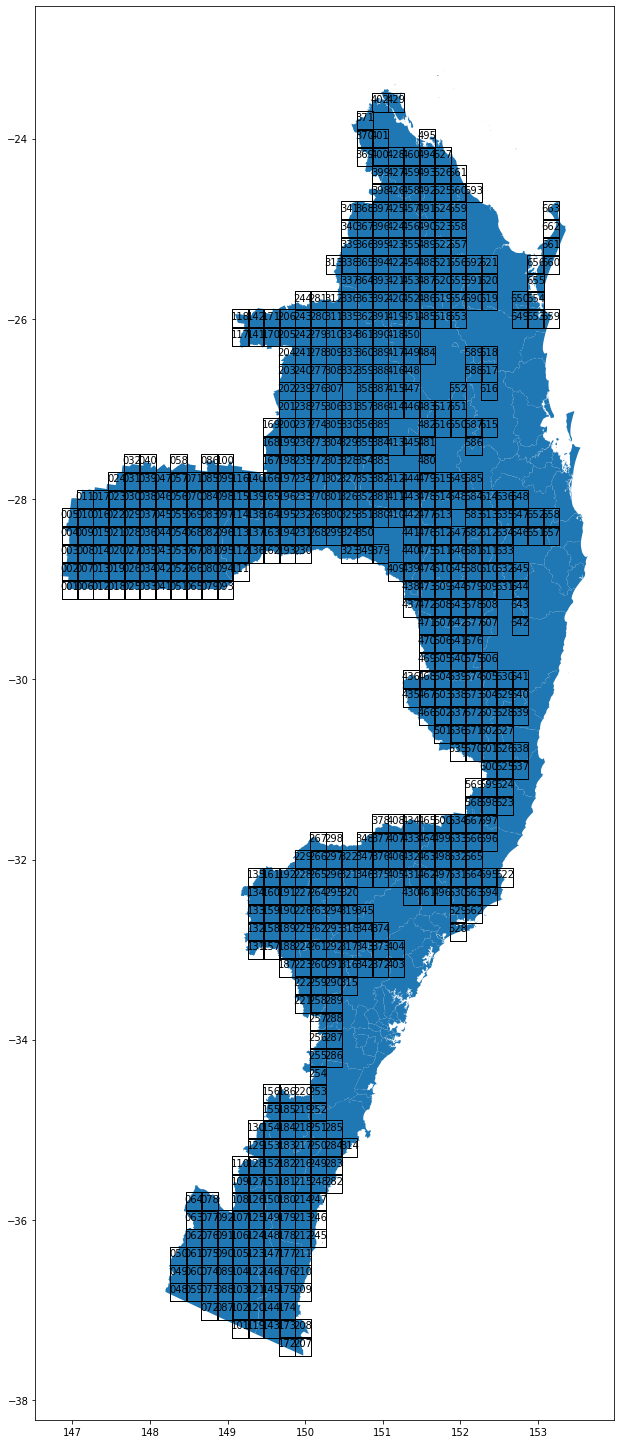

In [23]:
# Plot the existing polygons
ax = lgas.plot(figsize=(26, 26))
pols_existing.plot(ax=ax, facecolor="none")
for cent_x, cent_y, aoi_lab in zip(pols_existing.geometry.centroid.x, 
                                   pols_existing.geometry.centroid.y, 
                                   pols_existing.aoi_code):
    ax.annotate(aoi_lab[7:], (cent_x, cent_y), horizontalalignment='center')

In [20]:
# Save a copy the existing polygons locally
out_file = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/EMSR570/AOIs_existing/2022-08-08_aois.geojson"
pols_existing[["geometry","aoi_code"]].to_file(out_file,driver="GeoJSON")

## Generate new polygon tiles to fill gaps

In [25]:
verbose = False

# Set the tiling step and square tile size
step = 0.20, 0.20
size = 0.21

# Determine the maximum existing AOI code
idx_offset = max([int(x[7:]) for x in pols_existing.aoi_code.values])

# Iterate in X and Y from min_x and min_y to generate tiles
# bounds_lgas = [min_x, min_y, max_x, max_y]
pols_new = []
for idx, (x_left,y_bottom) in enumerate(itertools.product(np.arange(bounds_lgas[0], bounds_lgas[2], step[0]),
                                                          np.arange(bounds_lgas[1],bounds_lgas[3], step[1]))):
    
    aoi_num = idx + idx_offset + 1
    # Generate tile 
    bounds_iter = (x_left, y_bottom, x_left + size, y_bottom + size)
    pol = Polygon(generate_polygon(bounds_iter))
    
    # Calculate the intersection of the tile with the LGAs
    lgas_overlap_polygons = lgas.intersection(pol)
    lgas_overlap_polygons = lgas_overlap_polygons[~lgas_overlap_polygons.is_empty].copy()
    
    # Skip tile if it does not overlap any LGA
    if lgas_overlap_polygons.shape[0] == 0:
        continue
        
    # Skip tile if the LGA occupies < 0.2 of tile area
    min_frac_area = 0.01
    area_overlap_lga = lgas_overlap_polygons.area.sum() / pol.area
    if area_overlap_lga <= min_frac_area:
        if verbose:
            print(f"Skipping Tile {aoi_num} because of low filling fraction.")
        continue
    
    # Calculate the intersection of the tile with the existing polygons
    aoi_overlap_polygons = pols_existing.intersection(pol)
    aoi_overlap_polygons = aoi_overlap_polygons[~aoi_overlap_polygons.is_empty].copy()
    
    # Skip tile if it significantly overlaps any existing polygon
    max_frac_overlap = 0.3
    area_overlap = aoi_overlap_polygons.area.sum() / pol.area
    if area_overlap >= max_frac_overlap:
        if verbose:
            print(f"Skipping Tile {aoi_num} because of high overlap with existing tile.")
        continue
    if verbose:
        print(f"appending name AOI {aoi_num:04d}")
    pols_new.append({"geometry": pol, "name":f"AUTOAOI{aoi_num:04d}"})
    
pols_new = gpd.GeoDataFrame(pols_new, crs="EPSG:4326")
print(f"Added {pols_new.shape[0]} tiles.")
pols_new.head()

Added 292 tiles.


,geometry,name
0,"POLYGON ((146.86330 -28.10515, 147.07330 -28.1...",AUTOAOI0711
1,"POLYGON ((147.06330 -27.90515, 147.27330 -27.9...",AUTOAOI0784
2,"POLYGON ((147.26330 -27.90515, 147.47330 -27.9...",AUTOAOI0856
3,"POLYGON ((147.46330 -27.70515, 147.67330 -27.7...",AUTOAOI0929
4,"POLYGON ((148.06330 -36.90515, 148.27330 -36.9...",AUTOAOI1099


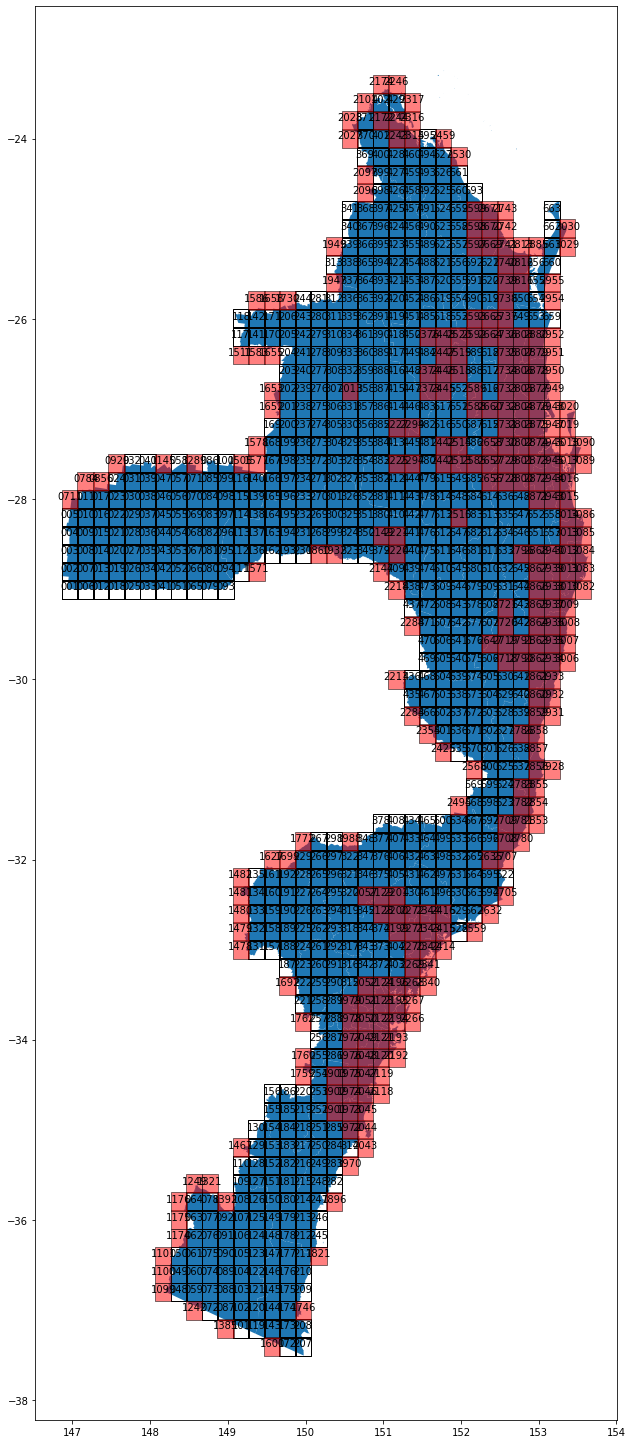

In [27]:
# Plot the old tiles and new (red)
ax = lgas.plot(figsize=(26, 26))
pols_existing.plot(ax=ax, facecolor="none")
pols_new.plot(ax=ax, edgecolor='black', facecolor='red', alpha=0.5)
for cent_x, cent_y, aoi_lab in zip(pols_existing.geometry.centroid.x,
                                   pols_existing.geometry.centroid.y,
                                   pols_existing.aoi_code):
    ax.annotate(aoi_lab[7:], (cent_x, cent_y), horizontalalignment='center')

for cent_x, cent_y, aoi_lab in zip(pols_new.geometry.centroid.x,
                                   pols_new.geometry.centroid.y,
                                   pols_new.name):
    ax.annotate(aoi_lab[7:], (cent_x, cent_y), horizontalalignment='center')

In [28]:
# Save new polygons locally
out_file = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/AOIs_new/2022-08-08_aois.geojson"
pols_new.to_file(out_file, driver="GeoJSON")